使用ANN网络输入高开低收和成交量作为输入

## 配置引擎参数

In [2]:
from pymongo import MongoClient
import pandas as pd
client = MongoClient('127.0.0.1', 27017)
db = client['VnTrader_1Min_Db']
collection = db['BTCUSDT:binance']
alldata = pd.DataFrame(list(collection.find()))

In [27]:

df1 = alldata[['datetime','open','high','low','close','volume']]

df1.loc[:,'datetime'] = pd.to_datetime(df1.loc[:,'datetime'])
df1.set_index("datetime", inplace=True)
ohlc_dict = {'open':'first','high':'max','low':'min','close':'last','volume':'sum'}

df_15 = df1.resample('15T', how=ohlc_dict, closed='left', label='left')
df_30 = df1.resample('30T', how=ohlc_dict, closed='left', label='left')
df_45 = df1.resample('45T', how=ohlc_dict, closed='left', label='left')
df_60 = df1.resample('60T', how=ohlc_dict, closed='left', label='left')
df_120 = df1.resample('120T', how=ohlc_dict, closed='left', label='left')
df_240 = df1.resample('240T', how=ohlc_dict, closed='left', label='left')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_laun

In [28]:
print(df_15.tail())
print(df_30.tail())
print(df_45.tail())
print(df_60.tail())
print(df_120.tail())
print(df_240.tail())

                        open     high      low    close       volume
datetime                                                            
2018-11-28 22:45:00  4232.00  4294.30  4231.25  4262.33  1578.615873
2018-11-28 23:00:00  4263.52  4266.00  4192.24  4199.17  1552.894668
2018-11-28 23:15:00  4199.18  4238.57  4180.00  4223.00  1362.073683
2018-11-28 23:30:00  4222.54  4232.62  4210.00  4215.59   892.341913
2018-11-28 23:45:00  4216.75  4254.51  4210.34  4249.82   732.110069
                        open     high     low    close       volume
datetime                                                           
2018-11-28 21:30:00  4207.30  4213.10  4170.0  4195.62  1939.122864
2018-11-28 22:00:00  4197.21  4254.45  4170.0  4237.14  2786.074782
2018-11-28 22:30:00  4238.39  4294.30  4230.0  4262.33  3190.978387
2018-11-28 23:00:00  4263.52  4266.00  4180.0  4223.00  2914.968351
2018-11-28 23:30:00  4222.54  4254.51  4210.0  4249.82  1624.451982
                        open     high    

In [42]:
#3周期滚动百分比变化
import numpy as np

data = df_120

data_open = (data['close'] - data['open'])/data['open']
data_open.name = 'open'
data_high = (data['high'] - data['open'])/data['open']
data_high.name = 'high'
data_low = (data['open'] - data['low'])/data['open']
data_low.name = 'low'
data_close = data['close'].pct_change()

data_volume = data['volume']

df = pd.concat([data_open, data_high, data_low, data_volume, data_close], axis = 1)
df = df.fillna(method='backfill')
print(data_open.name)
print(data_volume.name)
print(df.head())

open
volume
                         open      high       low       volume     close
datetime                                                                
2018-01-01 00:00:00  0.040589  0.060777  0.002581  1842.014160  0.001248
2018-01-01 02:00:00  0.000301  0.012629  0.005518   623.234037  0.001248
2018-01-01 04:00:00  0.011456  0.019373  0.000215   587.686796  0.011671
2018-01-01 06:00:00 -0.015337  0.005887  0.020457   532.737327 -0.016113
2018-01-01 08:00:00 -0.037373  0.000000  0.040849   827.053205 -0.037422


In [43]:
#提取用于训练ANN的特征,共4*4 = 16个，放置在一个数组中
total_num =len(df)-4

data_features = np.zeros((total_num, 4, 4))
data_labels = np.zeros((total_num))
up = 0.015
down = -0.015
for i in range(0, data_features.shape[0]):
    data_features[i] = [[df.iloc[i,0],df.iloc[i,1],df.iloc[i,2],df.iloc[i,3]],
                   [df.iloc[i+1,0],df.iloc[i+1,1],df.iloc[i+1,2],df.iloc[i+1,3]],
                   [df.iloc[i+2,0],df.iloc[i+2,1],df.iloc[i+2,2],df.iloc[i+2,3]],
                   [df.iloc[i+3,0],df.iloc[i+3,1],df.iloc[i+3,2],df.iloc[i+3,3]]
                   ]
    if df.iloc[i+4,4] > up:
        data_labels[i] = 2
    elif df.iloc[i+4,4] < down:
        data_labels[i] = 0
    else:
        data_labels[i] = 1
import numpy as np
result = np.zeros((3,1))
for k in [0,1,2]:
    mask = (data_labels == k)
    data_labels_new = data_labels[mask]
    v = data_labels_new.size
    result[k] = v
print(result)

[[ 353.]
 [3323.]
 [ 304.]]


3980


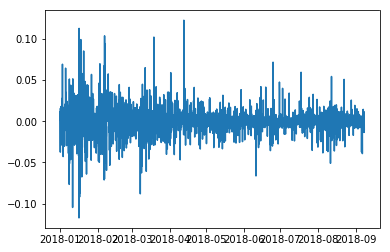

In [44]:
import matplotlib.pyplot as plt
plt.plot(df.iloc[0:3000,4])
print(total_num)

In [56]:
# 调用tensorflow进行ANN模型计算
#下面开始进行ANN计算
#加载库
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
train_features = data_features[0:3000]
train_labels = data_labels[0:3000]
test_features = data_features[0:3000]
test_labels = data_labels[0:3000]

#设置层
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(4, 4)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])  

model.compile(optimizer=tf.train.AdamOptimizer(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#开始训练模型
model.fit(train_features, train_labels, epochs=5)

#估计在测试集上的准确率
test_loss, test_acc = model.evaluate(test_features, test_labels)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Epoch 1/5
3000/3000 [==============================] - 1s 171us/step - loss: 11.0595 - acc: 0.3127
Epoch 2/5
3000/3000 [==============================] - 0s 50us/step - loss: 3.1738 - acc: 0.8030
Epoch 3/5
3000/3000 [==============================] - 0s 49us/step - loss: 3.1731 - acc: 0.8030
Epoch 4/5
3000/3000 [==============================] - 0s 49us/step - loss: 3.1726 - acc: 0.8030
Epoch 5/5
3000/3000 [==============================] - 0s 80us/step
Test accuracy: 0.8029999998410543
Test loss: 3.1719077688852946


In [60]:
predictions = model.predict(test_features)
print(predictions[1:100,:])
print(test_labels)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0.

In [17]:
import numpy as np


data_high = dv.get_ts('high',date_type='datetime')['BTCUSDT:binance']
data_high.name = 'high'
data_high = data_high/data_high.iloc[0:200].mean()

data_low = dv.get_ts('low',date_type='datetime')['BTCUSDT:binance']
data_low.name = 'low'
data_low = data_low/data_low.iloc[0:200].mean()

data_close = dv.get_ts('close',date_type='datetime')['BTCUSDT:binance']
data_close.name = 'close'
data_close = data_close/data_close.iloc[0:200].mean()

data_volume = dv.get_ts('volume',date_type='datetime')['BTCUSDT:binance']
data_volume.name = 'volume'
data_volume = data_volume/data_volume.iloc[0:200].mean()

data_return = dv.get_ts('close',date_type='datetime')['BTCUSDT:binance'].pct_change()
data_return.name = 'return'

,date,time,open,high,low,close
0,20180101,00:00:00,13226.16,13277.85,13192.02,13246.35
1,20180101,00:01:00,13277.83,13301.49,13246.50,13300.18
2,20180101,00:02:00,13280.06,13350.00,13267.71,13332.32
3,20180101,00:03:00,13313.02,13380.14,13313.02,13380.14
4,20180101,00:04:00,13369.99,13462.00,13359.45,13417.73
5,20180101,00:05:00,13420.05,13495.64,13420.05,13495.64
6,20180101,00:06:00,13490.99,13536.55,13490.03,13530.12
7,20180101,00:07:00,13505.15,13538.64,13458.88,13508.28
8,20180101,00:08:00,13508.28,13508.28,13460.80,13490.00
9,20180101,00:09:00,13490.00,13536.55,13488.01,13536.53


In [10]:
print(type(data.date[3]))

<class 'str'>


In [7]:
print(data.columns)

Index(['_id', 'close', 'date', 'datetime', 'exchange', 'high', 'low', 'open',
       'openInterest', 'symbol', 'time', 'volume', 'vtSymbol'],
      dtype='object')


In [1]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180901 12:00',initHours=0) # 设置回测用的数据起始日期
engine.setEndDate('20181123 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [3]:
print(engine.strategyStartDate)

2018-08-24 04:00:00


## 策略编写与参数设置

参数与变量的区别: 参数用来传递并且可以优化，变量是随着过程的赋值改变的

## CtaTemplate 继承的属性与方法
1. self.symbolList: 支持多品种以列表格式输入引擎
2. self.posDict: 可记录多个品种的多空持仓的字典
3. self.cancelAll(): 取消所有订单
4. self.getArrayManager(symbol, freq): 数组管理器

In [2]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class DoubleMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'DoubleMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    fastPeriod = 20     # 快速均线参数
    slowPeriod = 55    # 慢速均线参数
    lot = 1             # 设置手数
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am60.close, self.fastPeriod)
        slowMa = ta.EMA(am60.close, self.slowPeriod)
        
        crossOver = (fastMa[-1]>slowMa[-1]) and (fastMa[-2]<=slowMa[-2]) # 金叉上穿 
        crossBelow = (fastMa[-1]<slowMa[-1]) and (fastMa[-2]>=slowMa[-2]) # 死叉下穿

        
        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉时手头没有多头持仓
        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 如果金叉时手头没有空头持仓
        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [3]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
engine.initStrategy(DoubleMaStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function DoubleMaStrategy.on60MinBar at 0x000002478A81C9D8>, <__main__.DoubleMaStrategy object at 0x000002478A834518>)
2018-12-09 21:43:00.890004	开始回测
2018-12-09 21:43:00.890004	策略初始化
2018-12-09 21:43:00.891997	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-09 21:43:02.632766	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-09 21:43:02.634792	载入完成，数据量：12000
2018-12-09 21:43:02.635792	策略初始化完成
2018-12-09 21:43:02.635792	策略启动完成
2018-12-09 21:43:02.635792	开始回放回测数据,回测范围:[20180901 12:00,20181123 12:00)
2018-12-09 21:43:02.644734	载入历史数据。数据范围:[20180901 12:00,20181123 12:00)
2018-12-09 21:43:08.520256	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-09 21:43:08.544218	载入完成，数据量：118890
2018-12-09 21:43:08.544218	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种EOSUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-09 21:43:08.553169	载入历史数据。数据范围:[20180831 20:51,201809

In [4]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-11-13 18:00:00,空,,,0.0,,开仓,45,,5.3942,0.0,None,,,45,2018-11-13 18:00:00,1,45,EOSUSDT:binance,45
2018-11-14 01:00:00,多,,,0.0,,平仓,46,,5.4697,0.0,None,,,46,2018-11-14 01:00:00,1,46,EOSUSDT:binance,46
2018-11-14 01:00:00,多,,,0.0,,开仓,47,,5.4697,0.0,None,,,47,2018-11-14 01:00:00,1,47,EOSUSDT:binance,47
2018-11-14 03:00:00,空,,,0.0,,平仓,48,,5.1702,0.0,None,,,48,2018-11-14 03:00:00,1,48,EOSUSDT:binance,48
2018-11-14 03:00:00,空,,,0.0,,开仓,49,,5.1702,0.0,None,,,49,2018-11-14 03:00:00,1,49,EOSUSDT:binance,49


## 查看绩效回测绩效

2018-12-09 21:44:07.774904	计算按日统计结果
2018-12-09 21:44:07.854974	------------------------------
2018-12-09 21:44:07.854974	首个交易日：	2018-09-01 00:00:00
2018-12-09 21:44:07.855974	最后交易日：	2018-11-23 00:00:00
2018-12-09 21:44:07.855974	总交易日：	84
2018-12-09 21:44:07.855974	盈利交易日	39
2018-12-09 21:44:07.855974	亏损交易日：	42
2018-12-09 21:44:07.855974	起始资金：	1000000
2018-12-09 21:44:07.855974	结束资金：	1,000,002.22
2018-12-09 21:44:07.855974	总收益率：	0.0%
2018-12-09 21:44:07.855974	年化收益：	0.0%
2018-12-09 21:44:07.855974	总盈亏：	2.22
2018-12-09 21:44:07.855974	最大回撤: 	-1.26
2018-12-09 21:44:07.855974	百分比最大回撤: -0.0%
2018-12-09 21:44:07.855974	总手续费：	0.14
2018-12-09 21:44:07.855974	总滑点：	0.1
2018-12-09 21:44:07.855974	总成交金额：	271.25
2018-12-09 21:44:07.855974	总成交笔数：	49
2018-12-09 21:44:07.855974	日均盈亏：	0.03
2018-12-09 21:44:07.855974	日均手续费：	0.0
2018-12-09 21:44:07.855974	日均滑点：	0.0
2018-12-09 21:44:07.856969	日均成交金额：	3.23
2018-12-09 21:44:07.856969	日均成交笔数：	0.58
2018-12-09 21:44:07.856969	日均收益率：	0.0%
2018-12-09 21:44:07.856

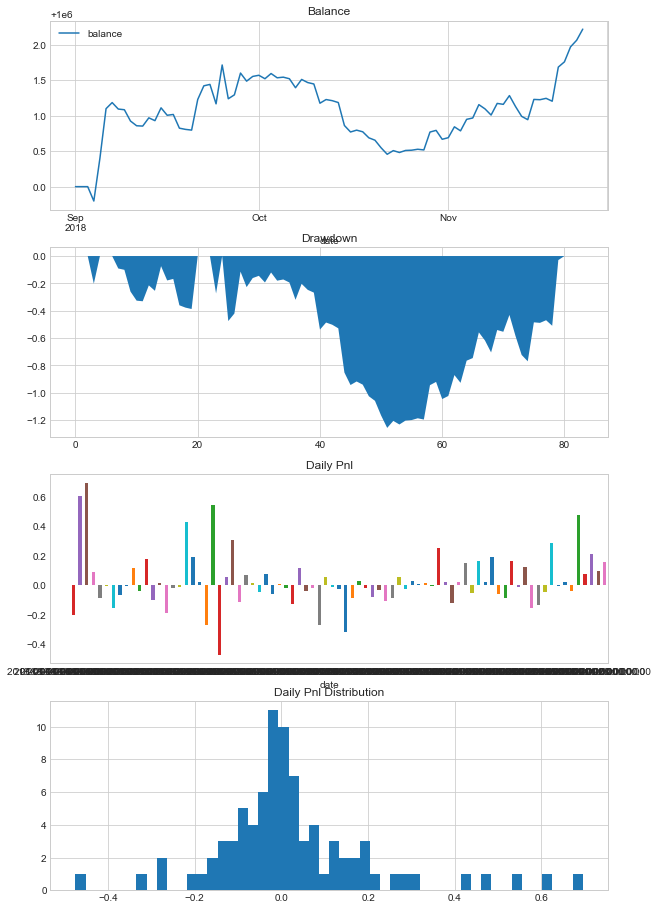

In [5]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-09 21:44:14.548833	计算回测结果
2018-12-09 21:44:14.550826	------------------------------
2018-12-09 21:44:14.550826	第一笔交易：	2018-09-05 00:00:00
2018-12-09 21:44:14.550826	最后一笔交易：	2018-11-23 11:58:00
2018-12-09 21:44:14.550826	总交易次数：	25
2018-12-09 21:44:14.550826	总盈亏：	2.21
2018-12-09 21:44:14.550826	最大回撤: 	-1.02
2018-12-09 21:44:14.550826	平均每笔盈利：	0.09
2018-12-09 21:44:14.550826	平均每笔滑点：	0.0
2018-12-09 21:44:14.550826	平均每笔佣金：	0.01
2018-12-09 21:44:14.550826	胜率		40.0%
2018-12-09 21:44:14.551823	盈利交易平均值	0.44
2018-12-09 21:44:14.551823	亏损交易平均值	-0.15
2018-12-09 21:44:14.551823	盈亏比：	2.99


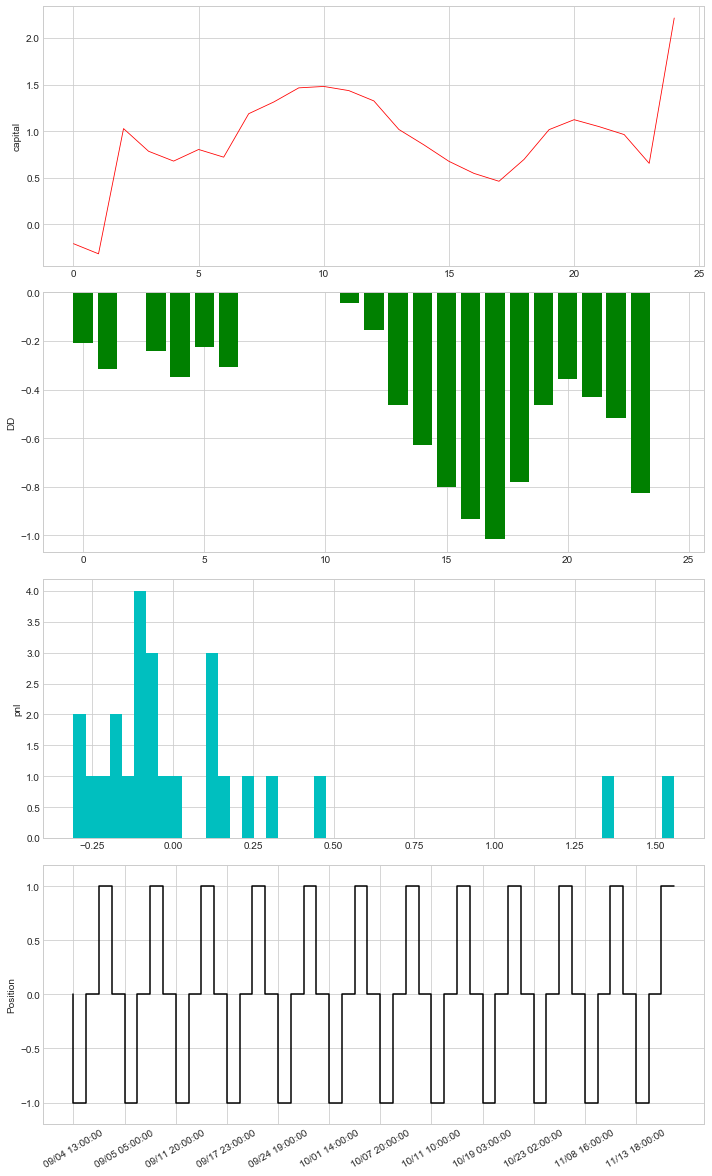

In [6]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [7]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-09 21:44:21.928994	计算按日统计结果


In [8]:
print(pd.Series(result)) # 显示绩效指标

startDate           2018-09-01 00:00:00
endDate             2018-11-23 00:00:00
totalDays                            84
profitDays                           39
lossDays                             42
endBalance                        1e+06
maxDrawdown                    -1.25684
maxDdPercent               -0.000125684
totalNetPnl                     2.21717
dailyNetPnl                   0.0263949
totalCommission                0.135626
dailyCommission              0.00161459
totalSlippage                     0.098
dailySlippage                0.00116667
totalTurnover                   271.252
dailyTurnover                   3.22919
totalTradeCount                      49
dailyTradeCount                0.583333
totalReturn                 0.000221717
annualizedReturn            0.000633478
dailyReturn                 2.63949e-06
returnStd                   1.85059e-05
sharpeRatio                     2.20961
dtype: object
